In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
%matplotlib inline
from segmentation_models_pytorch import utils as smpu
import seaborn as sns
from lgbt import lgbt

In [2]:
DATA_DIR = 'dataset/tiff'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_val_dir = os.path.join(DATA_DIR, 'val')
y_val_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_dict = pd.read_csv("./dataset/label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

select_classes = ['background', 'road']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [3]:
# Функция для визуализации изображений
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [4]:
# Функция для one-hot кодирования масок
def one_hot_encode(label, label_values):
  semantic_map = []
  for colour in label_values:
      equality = np.equal(label, colour)
      class_map = np.all(equality, axis = -1)
      semantic_map.append(class_map)
  semantic_map = np.stack(semantic_map, axis=-1)

  return semantic_map

def reverse_one_hot(image):
  x = np.argmax(image, axis = -1)
  return x

def colour_code_segmentation(image, label_values):
  colour_codes = np.array(label_values)
  x = colour_codes[image.astype(int)]

  return x

In [5]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([album.HorizontalFlip(p=1),
                     album.VerticalFlip(p=1),
                     album.RandomRotate90(p=1)],
                     p=0.75)]

    return album.Compose(train_transform)

def get_valation_augmentation():
    test_transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)]

    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []

    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

In [6]:
sns.set_style("whitegrid")

plt.style.use('ggplot')

def plot_training_metrics(train_logs_list, val_logs_list, save_path=None):
    """
    Визуализирует метрики обучения (loss и IoU) для тренировочного и валидационного наборов.
    
    Параметры:
        train_logs_list (list): Список логов тренировочных эпох
        val_logs_list (list): Список логов валидационных эпох
        save_path (str, optional): Путь для сохранения графиков. Если None - график только отобразится.
    """
    # Извлекаем метрики из логов
    train_loss = [log['dice_loss'] for log in train_logs_list]
    val_loss = [log['dice_loss'] for log in val_logs_list]
    
    train_iou = [log['iou_score'] for log in train_logs_list]
    val_iou = [log['iou_score'] for log in val_logs_list]
    
    epochs = range(1, len(train_logs_list) + 1)
    
    # Создаем фигуру с двумя subplots
    plt.figure(figsize=(15, 6))
    
    # График для Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # График для IoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_iou, label='Training IoU')
    plt.plot(epochs, val_iou, label='Validation IoU')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    
    plt.show()

In [7]:
class RoadsDataset(torch.utils.data.Dataset):

  def __init__(self, images_dir, masks_dir, class_rgb_values=None,
               augmentation=None, preprocessing=None):
    self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
    self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
    self.class_rgb_values = class_rgb_values
    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __getitem__(self, i):
    image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
    mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

    if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

    if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

    return image, mask

  def __len__(self):
        return len(self.image_paths)

In [8]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
train_dataset = RoadsDataset(x_train_dir, y_train_dir,
                             augmentation=get_training_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn),
                             class_rgb_values=select_class_rgb_values)

val_dataset = RoadsDataset(x_val_dir, y_val_dir,
                             augmentation=get_valation_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn),
                             class_rgb_values=select_class_rgb_values)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

/tmp/ipykernel_1044037/1752006510.py:3: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  album.RandomCrop(height=256, width=256, always_apply=True),
/tmp/ipykernel_1044037/1752006510.py:12: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  test_transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)]


In [10]:
TRAINING = True
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

loss = smpu.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.00008)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

cuda


In [11]:
train_epoch = smp.utils.train.TrainEpoch(model, loss=loss, metrics=metrics,
                                         optimizer=optimizer, device=DEVICE,
                                         verbose=True)

val_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics,
                                         device=DEVICE, verbose=True)


Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00,  7.38it/s, dice_loss - 0.3316, iou_score - 0.6144]
Model saved

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00,  7.35it/s, dice_loss - 0.2871, iou_score - 0.6552]
Model saved

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00,  7.35it/s, dice_loss - 0.2591, iou_score - 0.8214]
Model saved

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00,  7.18it/s, dice_loss - 0.2255, iou_score - 0.8471]
Model saved

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00,  7.31it/s, dice_loss - 0.2014, iou_score - 0.8468]


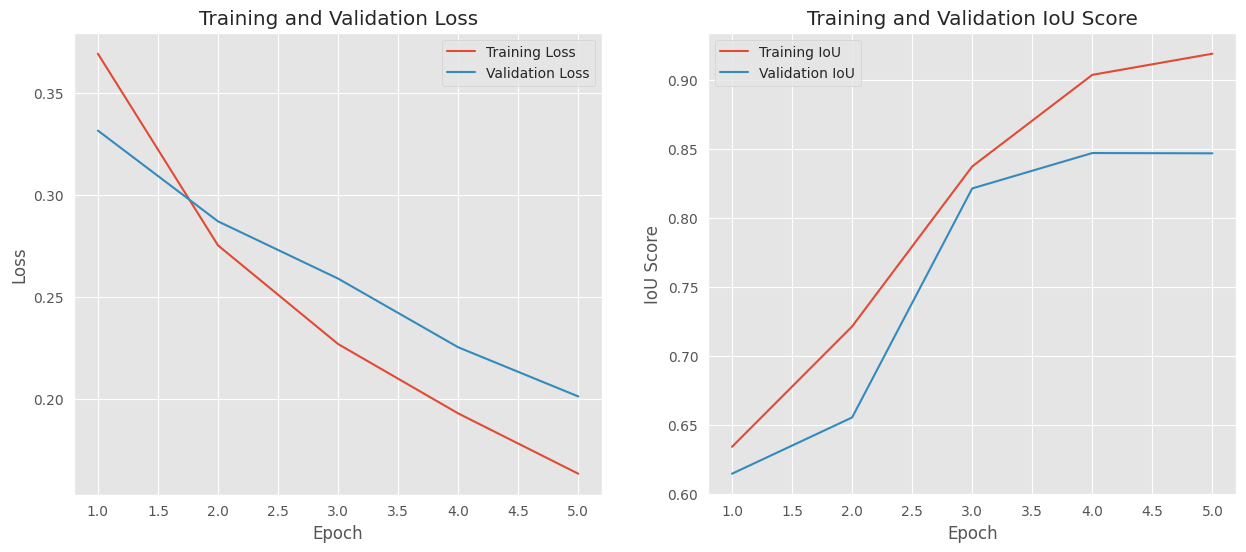

In [12]:
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, val_logs_list = [], []

    for i in range(0, EPOCHS):
        print('\nEpoch: {}'.format(i+1))
        train_logs = train_epoch.run(train_loader)
        val_logs = val_epoch.run(val_loader)
        train_logs_list.append(train_logs)
        val_logs_list.append(val_logs)

        if best_iou_score < val_logs['iou_score']:
            best_iou_score = val_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved')
    
    # Визуализация метрик после обучения
    plot_training_metrics(train_logs_list, val_logs_list, save_path='./metrics_plots')

In [13]:
test_dataset = RoadsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_valation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_valation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

preds_folder = 'predictions/'
if not os.path.exists(preds_folder):
  os.makedirs(preds_folder)

/tmp/ipykernel_1044037/1752006510.py:12: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  test_transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)]


[ WARN:0@238.163] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


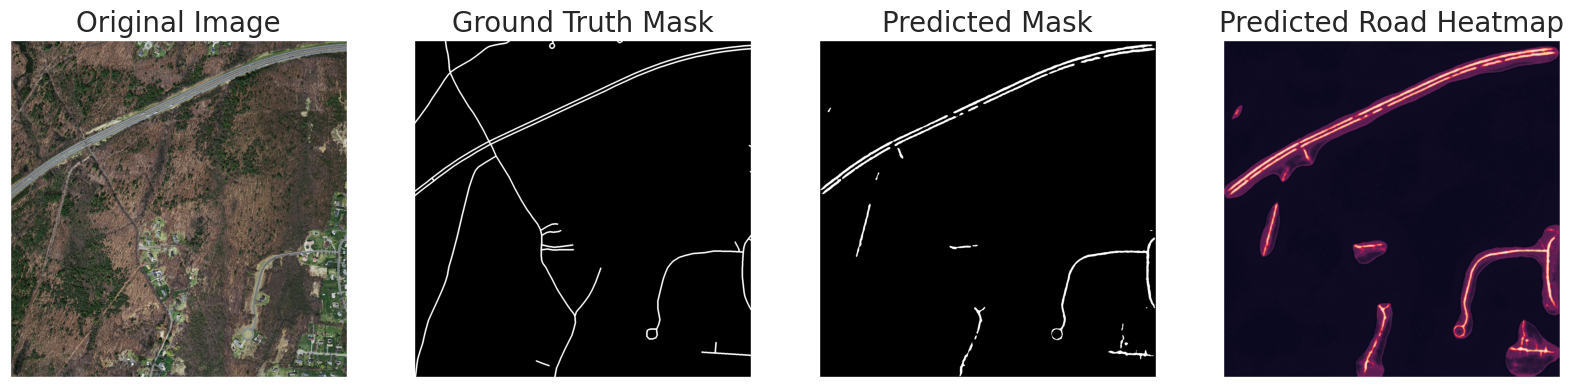

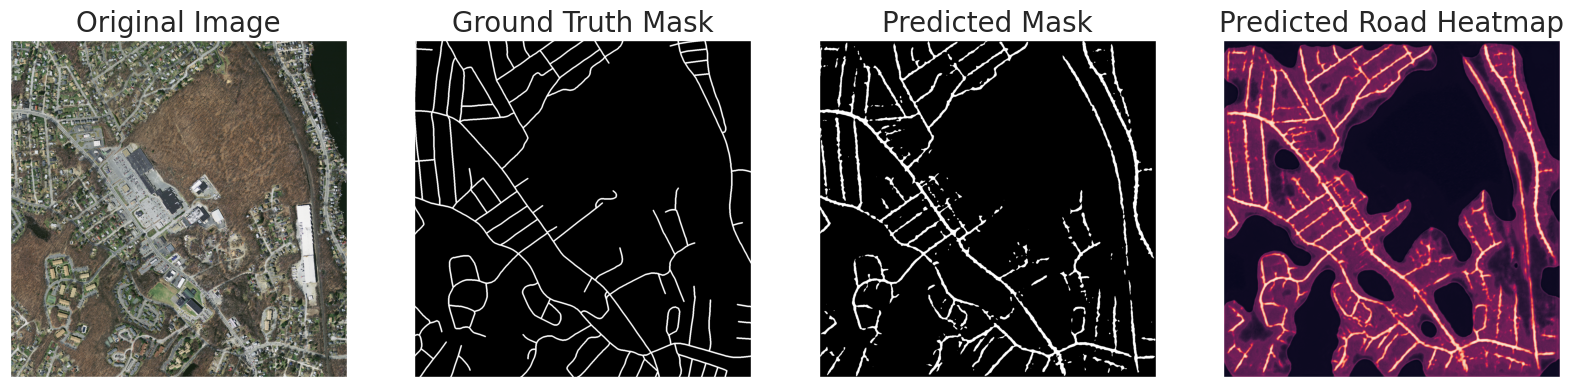

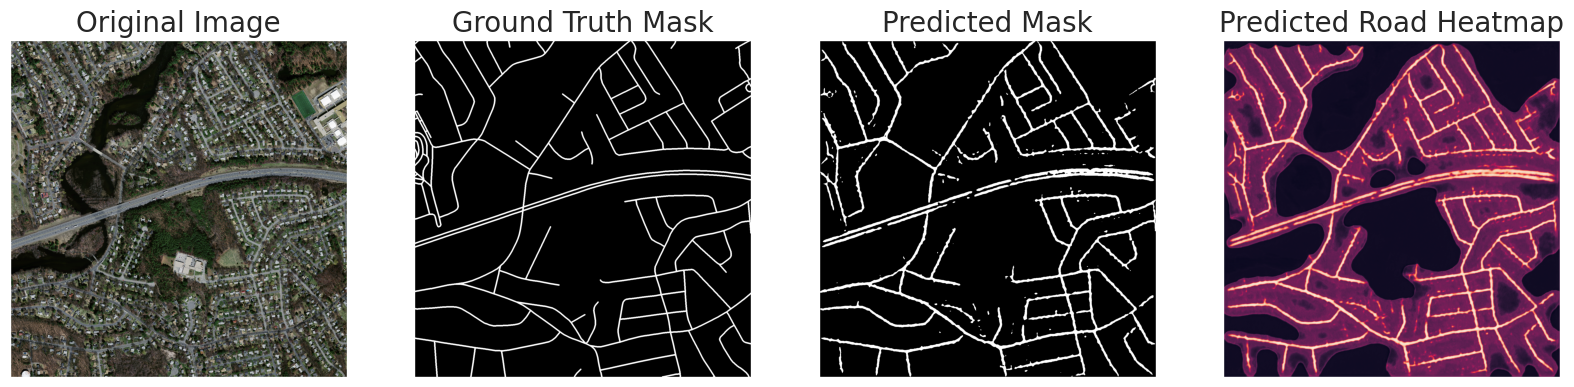

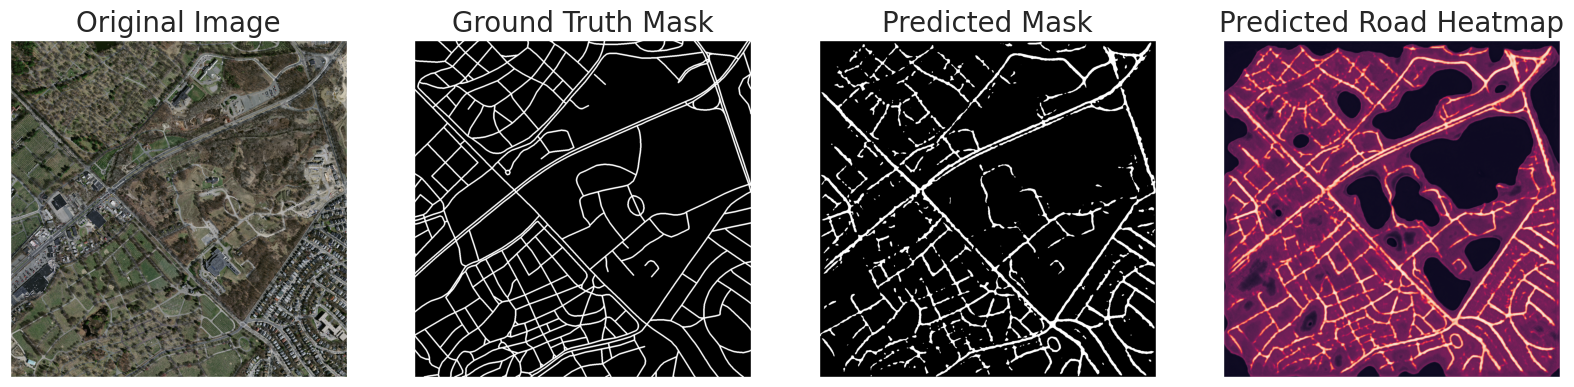

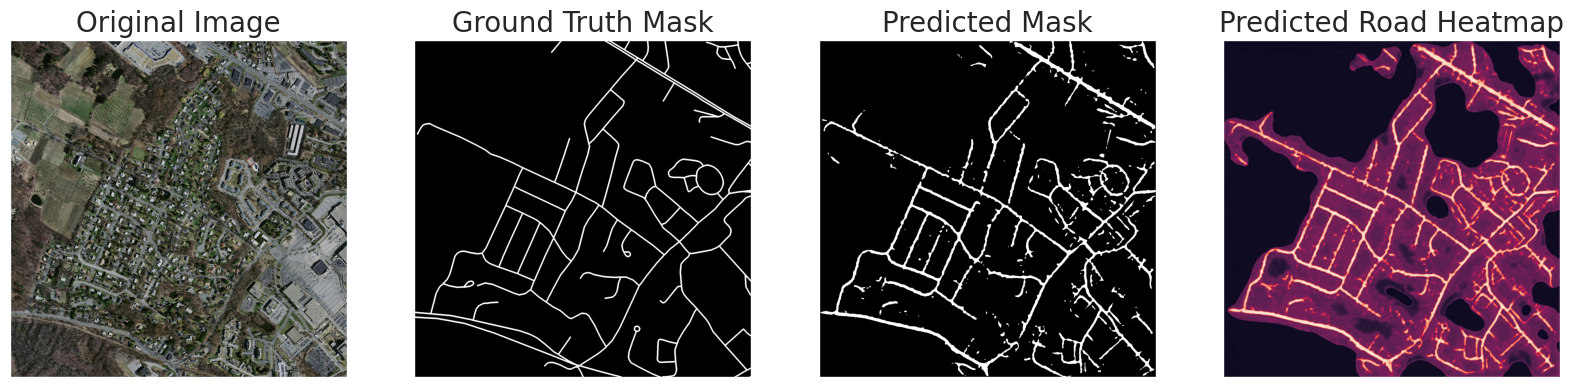

In [15]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = model(x_tensor)
    if idx % 10 == 0:
      pred_mask = pred_mask.detach().squeeze().cpu().numpy()
      # Convert pred_mask from `CHW` format to `HWC` format
      pred_mask = np.transpose(pred_mask,(1,2,0))
      # Get prediction channel corresponding to road
      pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
      pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
      # Convert gt_mask from `CHW` format to `HWC` format
      gt_mask = np.transpose(gt_mask,(1,2,0))
      gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
      cv2.imwrite(os.path.join(preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

      visualize(
          original_image = image_vis,
          ground_truth_mask = gt_mask,
          predicted_mask = pred_mask,
          predicted_road_heatmap = pred_road_heatmap
      )